In [1]:
from pyscf import gto, scf, cc
import numpy as np
from jax import numpy as jnp
from jax import vmap, jit
import jax
from functools import partial

atoms = '''
O        0.0000000000      0.0000000000      0.0000000000
H        0.9562300000      0.0000000000      0.0000000000
H       -0.2353791634      0.9268076728      0.0000000000
'''

frozen = 1

mol = gto.M(atom=atoms,
            basis='6-31g',
            spin=0,
            unit='A',
            verbose=4)
mol.build()

mf = scf.UHF(mol)
mf.kernel()

mo = mf.stability()[0]
dm = mf.make_rdm1(mo,mf.mo_occ)
mf.kernel(dm0=dm)
mo = mf.stability()[0]
dm = mf.make_rdm1(mo,mf.mo_occ)
mf.kernel(dm0=dm)


nfrozen = 0
mycc = cc.CCSD(mf,frozen=nfrozen)
mycc.kernel()[0]

et = mycc.ccsd_t()

System: uname_result(system='Linux', node='sharmagroup-rn', release='6.14.0-37-generic', version='#37~24.04.1-Ubuntu SMP PREEMPT_DYNAMIC Thu Nov 20 10:25:38 UTC 2', machine='x86_64')  Threads 16
Python 3.11.14 (main, Oct 21 2025, 18:31:21) [GCC 11.2.0]
numpy 2.3.1  scipy 1.16.2  h5py 3.14.0
Date: Wed Feb  4 11:28:31 2026
PySCF version 2.11.0
PySCF path  /home/sharmagroup/sharmagroup/pyscf
GIT HEAD (branch master) 3d1768f5e33b144b606c3d2c81c12ee54d794501

[ENV] PYSCF_EXT_PATH /home/sharmagroup/sharmagroup/pyscf-forge
[CONFIG] conf_file None
[INPUT] verbose = 4
[INPUT] num. atoms = 3
[INPUT] num. electrons = 10
[INPUT] charge = 0
[INPUT] spin (= nelec alpha-beta = 2S) = 0
[INPUT] symmetry False subgroup None
[INPUT] Mole.unit = A
[INPUT] Symbol           X                Y                Z      unit          X                Y                Z       unit  Magmom
[INPUT]  1 O      0.000000000000   0.000000000000   0.000000000000 AA    0.000000000000   0.000000000000   0.000000000000 Bohr 

In [8]:
e_fci = -76.1197480231290 

In [2]:
data = np.load('/home/sharmagroup/sharmagroup/project/abs/h2o/traject.npz')
t = data["time"]
wts = data["weights"]
ens = data["energies"]

In [18]:
t0 = np.hstack([[0], t])
ntrj = wts.shape[1]
e_init = jnp.full((1, ntrj), mycc.e_tot)
wt_init = jnp.full((1, ntrj), 200.)
ens0 = np.vstack([e_init, ens])
wts0 = np.vstack([wt_init, wts])
# print(ens_mod.shape)

In [19]:
mean = ens0.mean(axis=1)

In [20]:
std = np.sqrt(np.sum((ens0 - mean[:,None])**2,axis=1))/ntrj

In [6]:
mean

array([-75.98390198+0.00000000e+00j, -76.11827951+2.43843077e-06j,
       -76.11953974+2.37156330e-05j, -76.11973017+1.74645309e-05j,
       -76.11968655-1.83314831e-05j, -76.11959592-4.43723374e-05j,
       -76.11987671+3.98430012e-05j, -76.12009049-5.37908222e-06j,
       -76.12012595-3.81082550e-05j, -76.11979698-6.88389833e-05j,
       -76.11992194-5.78650475e-05j, -76.11988224+2.16616119e-05j,
       -76.11981017+1.59644764e-05j, -76.11985908+3.06772391e-05j,
       -76.12000439+3.30682534e-05j, -76.11983303+9.77548951e-05j,
       -76.11981041-1.40808602e-05j, -76.11982027+1.19152795e-06j,
       -76.11988942-8.91832069e-05j, -76.11978817-2.49475872e-05j,
       -76.1200242 -5.47292873e-05j])

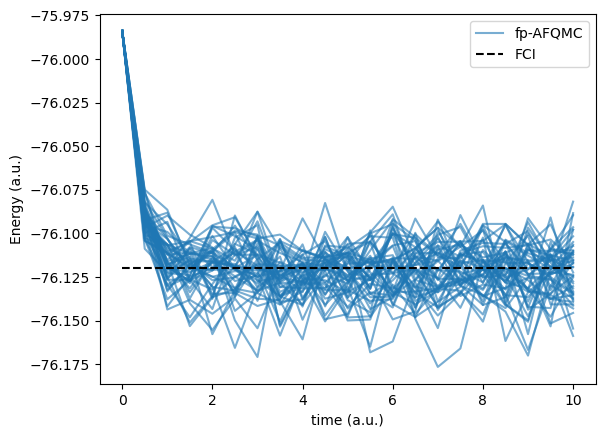

In [67]:
from matplotlib import pyplot as plt
plt.plot(t0, ens0[:,:1].real,'-',color="C0", alpha=0.6, label='fp-AFQMC')
plt.plot(t0, ens0[:,1:50].real,'-',color="C0", alpha=0.6)
plt.plot(t0,[e_fci]*len(t0), '--',label='FCI',color='black')
plt.xlabel("time (a.u.)")
plt.ylabel("Energy (a.u.)")
plt.legend()
plt.show()

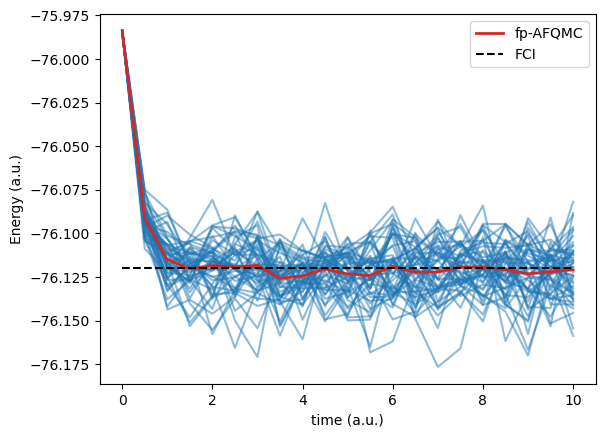

In [79]:
from matplotlib import pyplot as plt
plt.plot(t0, ens0.real,'-',color="C0", alpha=0.5)
# plt.plot(t0, ens0[:,1].real,'o-',label='fp2',color='C1')
# plt.plot(t0, ens0[:,2].real,'o-',label='fp3',color='C2')
# plt.errorbar(t0, mean.real, std.real*2, fmt='.-',capsize=5, color="C3", label='fp-AFQMC')
plt.plot(t0, mean.real, linewidth=2, color="C3", label='fp-AFQMC')
# plt.plot(t0,[mycc.e_tot + et]*len(t0), '--',label='CCSD(T)',color='C4')
plt.plot(t0,[e_fci]*len(t0), '--',label='FCI',color='black')
plt.xlabel("time (a.u.)")
plt.ylabel("Energy (a.u.)")
plt.legend()
plt.show()

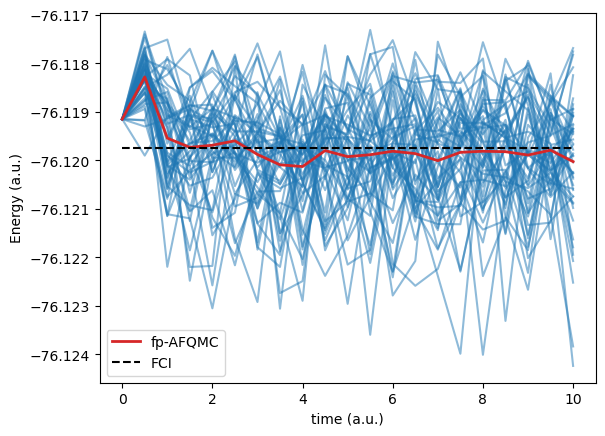

In [21]:
from matplotlib import pyplot as plt
plt.plot(t0, ens0.real,'-',color="C0", alpha=0.5)
# plt.plot(t0, ens0[:,1].real,'o-',label='fp2',color='C1')
# plt.plot(t0, ens0[:,2].real,'o-',label='fp3',color='C2')
# plt.errorbar(t0, mean.real, std.real*2, fmt='.-',capsize=5, color="C3", label='fp-AFQMC')
plt.plot(t0, mean.real, linewidth=2, color="C3", label='fp-AFQMC')
# plt.plot(t0,[mycc.e_tot + et]*len(t0), '--',label='CCSD(T)',color='C4')
plt.plot(t0,[e_fci]*len(t0), '--',label='FCI',color='black')
plt.xlabel("time (a.u.)")
plt.ylabel("Energy (a.u.)")
plt.legend()
plt.show()

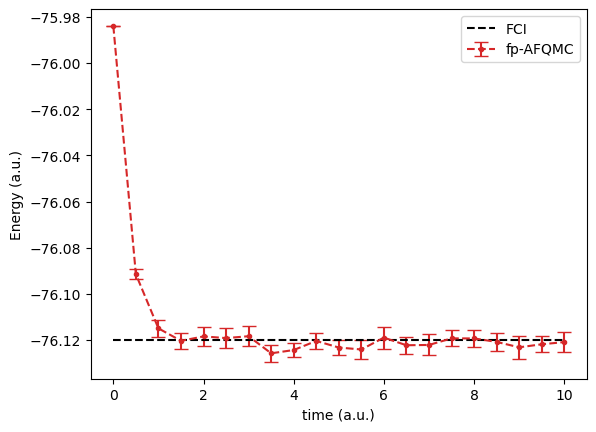

In [76]:
plt.errorbar(t0, mean.real, std.real*2, fmt='.--',capsize=5, color="C3", label='fp-AFQMC')
plt.plot(t0,[e_fci]*len(t0), '--',label='FCI',color='black')
plt.xlabel("time (a.u.)")
plt.ylabel("Energy (a.u.)")
plt.legend()
plt.show()